# Dairy Sales



In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib


In [3]:

# Load cleaned dataset
df = pd.read_csv(r"C:\Users\manga\Downloads\dairy_dataset.csv")
df.head()


,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40


In [4]:
# Detect correct column name for Quantity Sold
col_candidates = [c for c in df.columns if "Quantity" in c and "Sold" in c]
print("Detected column:", col_candidates)

# Use the first match
quantity_col = col_candidates[0]

# Target: classify sales quantity into Low, Medium, High using quartiles
q25 = df[quantity_col].quantile(0.25)
q75 = df[quantity_col].quantile(0.75)

def categorize_sales(x):
    if x <= q25:
        return "Low"
    elif x >= q75:
        return "High"
    else:
        return "Medium"

df['Sales_Category'] = df[quantity_col].apply(categorize_sales)
df['Sales_Category'].value_counts()


Detected column: ['Quantity Sold (liters/kg)']


Sales_Category
Medium    2158
Low       1084
High      1083
Name: count, dtype: int64

In [5]:
# Detect correct Quantity Sold column
col_candidates = [c for c in df.columns if "Quantity" in c and "Sold" in c]
quantity_col = col_candidates[0]

# Features (exclude target & identifier columns)
drop_cols = ['Sales_Category', 'Date', quantity_col]
X = df.drop(columns=[c for c in drop_cols if c in df.columns])
y = df['Sales_Category']

# One-hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

X.shape, y.shape


((4325, 2911), (4325,))

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [7]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

        High       0.68      0.56      0.61       216
         Low       0.50      0.54      0.52       217
      Medium       0.59      0.62      0.60       432

    accuracy                           0.58       865
   macro avg       0.59      0.57      0.58       865
weighted avg       0.59      0.58      0.58       865

Accuracy: 0.5838150289017341


In [8]:

rf_model = RandomForestClassifier(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Classification Report:\n")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest Classification Report:

              precision    recall  f1-score   support

        High       0.96      0.79      0.87       216
         Low       0.93      0.74      0.82       217
      Medium       0.80      0.95      0.87       432

    accuracy                           0.86       865
   macro avg       0.90      0.83      0.85       865
weighted avg       0.87      0.86      0.86       865

Accuracy: 0.8589595375722543


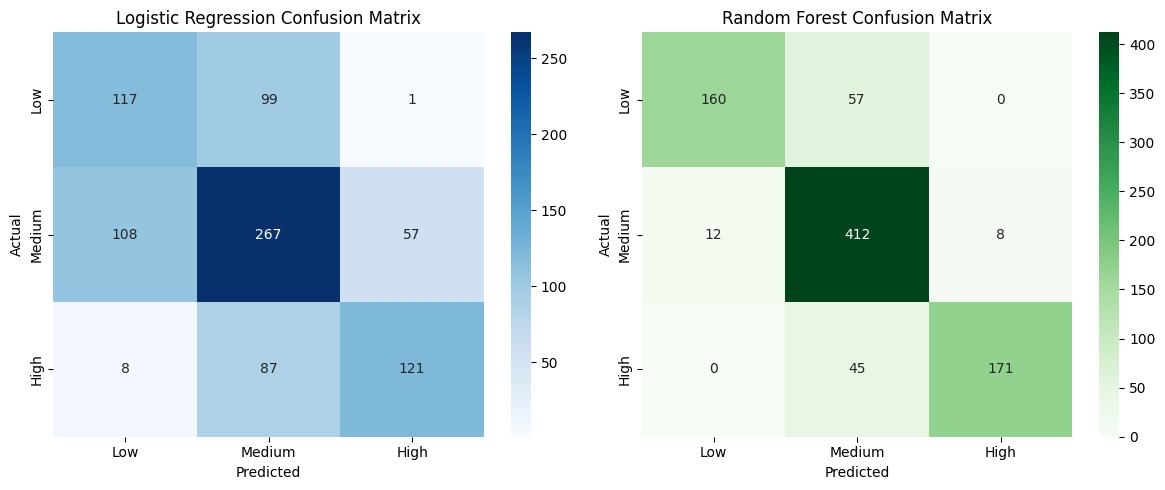

In [9]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# LR confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr, labels=['Low','Medium','High'])
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'], ax=axes[0])
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# RF confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=['Low','Medium','High'])
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=['Low','Medium','High'], yticklabels=['Low','Medium','High'], ax=axes[1])
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


RandomForestRegressor metrics on test set:
MAE:  7.3462
MSE:  104.7790
RMSE: 10.2362
R2:   0.9977


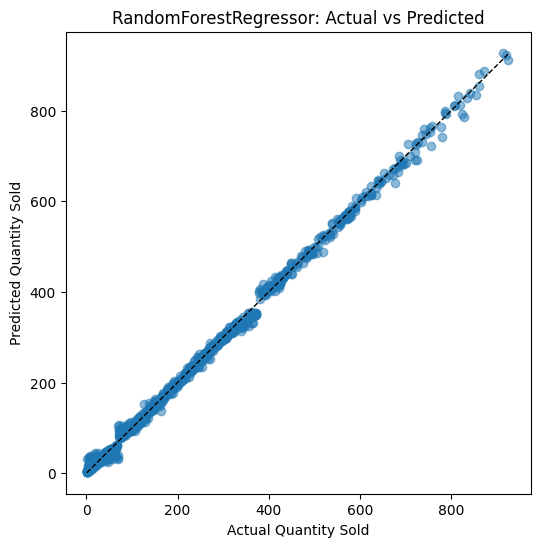

['random_forest_regressor.pkl']

In [10]:
# === RandomForestRegressor: regression metrics + Actual vs Predicted plot ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# detect quantity column (use existing variable if present)
try:
    qty_col = quantity_col  # if defined earlier
except NameError:
    qty_candidates = [c for c in df.columns if "Quantity" in c and "Sold" in c]
    qty_col = qty_candidates[0]

# Prepare regression dataset (drop target, date, and known leakage columns)
leakage_candidates = [c for c in df.columns if any(k in c.lower() for k in ['revenue', 'sales_efficiency', 'approx. total revenue', 'revenue_per_quantity'])]
drop_cols = [qty_col, 'Date'] + leakage_candidates
X_reg = df.drop(columns=[c for c in drop_cols if c in df.columns])
y_reg = df[qty_col].astype(float)  # ensure numeric

# One-hot encode categorical features (same preprocessing as classifier)
X_reg = pd.get_dummies(X_reg, drop_first=True)

# Train/test split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=200, random_state=42)
rfr.fit(Xr_train, yr_train)
yr_pred = rfr.predict(Xr_test)

# Regression metrics
mae = mean_absolute_error(yr_test, yr_pred)
mse = mean_squared_error(yr_test, yr_pred)
rmse = np.sqrt(mse)
r2 = r2_score(yr_test, yr_pred)

print(f"RandomForestRegressor metrics on test set:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")

# Actual vs Predicted scatter with 45-degree reference line
plt.figure(figsize=(6,6))
plt.scatter(yr_test, yr_pred, alpha=0.5)
mn = min(yr_test.min(), yr_pred.min())
mx = max(yr_test.max(), yr_pred.max())
plt.plot([mn,mx], [mn,mx], 'k--', linewidth=1)
plt.xlabel('Actual Quantity Sold')
plt.ylabel('Predicted Quantity Sold')
plt.title('RandomForestRegressor: Actual vs Predicted')
plt.show()

# Save regressor (optional)
joblib.dump(rfr, "random_forest_regressor.pkl")


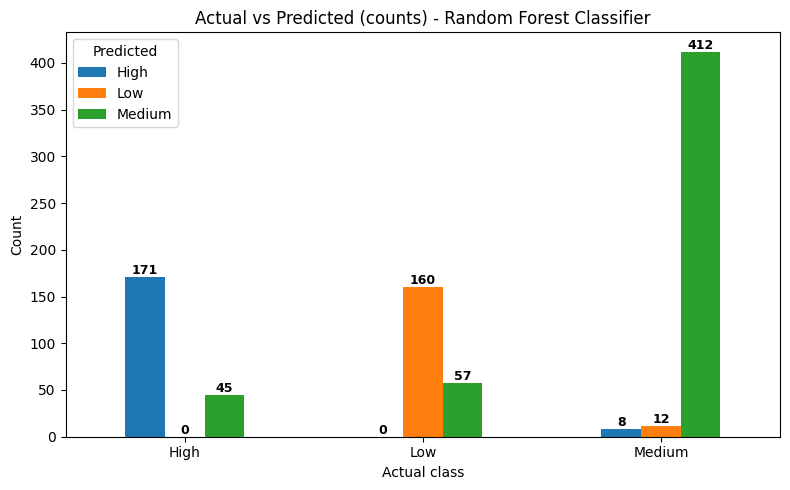

In [11]:

# Actual vs Predicted counts (classification)
df_compare = pd.DataFrame({'Actual': y_test.reset_index(drop=True), 'Predicted': y_pred_rf})
ct = pd.crosstab(df_compare['Actual'], df_compare['Predicted'])

# grouped bar plot
ax = ct.plot(kind='bar', figsize=(8,5))
plt.title('Actual vs Predicted (counts) - Random Forest Classifier')
plt.xlabel('Actual class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Predicted')
plt.tight_layout()

# Add numbers on top of each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9, fontweight='bold')

plt.show()



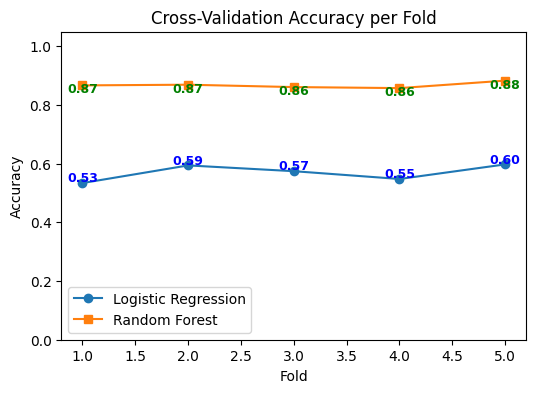

LR CV Mean Accuracy: 0.5697109826589595
RF CV Mean Accuracy: 0.8677456647398843


In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression CV
cv_scores_lr = cross_val_score(lr_model, scaler.fit_transform(X), y, cv=cv, scoring='accuracy')

# Random Forest CV
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')

plt.figure(figsize=(6,4))
plt.plot(range(1, 6), cv_scores_lr, marker='o', label="Logistic Regression")
plt.plot(range(1, 6), cv_scores_rf, marker='s', label="Random Forest")

# Add numbers on each point
for i, score in enumerate(cv_scores_lr, start=1):
    plt.text(i, score+0.005, f"{score:.2f}", ha='center', fontsize=9, fontweight='bold', color='blue')

for i, score in enumerate(cv_scores_rf, start=1):
    plt.text(i, score-0.025, f"{score:.2f}", ha='center', fontsize=9, fontweight='bold', color='green')

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Accuracy per Fold")
plt.legend()
plt.ylim(0, 1.05)  # keep space for labels
plt.show()

print("LR CV Mean Accuracy:", np.mean(cv_scores_lr))
print("RF CV Mean Accuracy:", np.mean(cv_scores_rf))


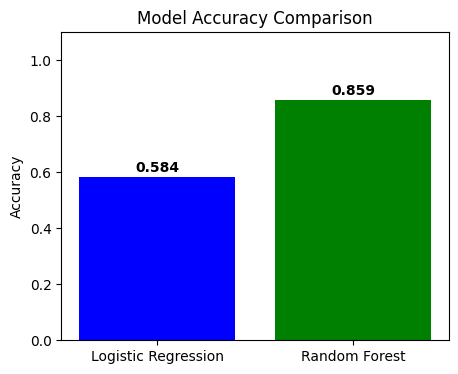

In [13]:
# Collect test accuracies
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_rf = accuracy_score(y_test, y_pred_rf)

accuracies = [acc_lr, acc_rf]
labels = ["Logistic Regression", "Random Forest"]

plt.figure(figsize=(5,4))
bars = plt.bar(labels, accuracies, color=["blue", "green"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

# Add accuracy values on top of bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f"{acc:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.ylim(0, 1.1)  # adjust y-limit so labels are visible
plt.show()


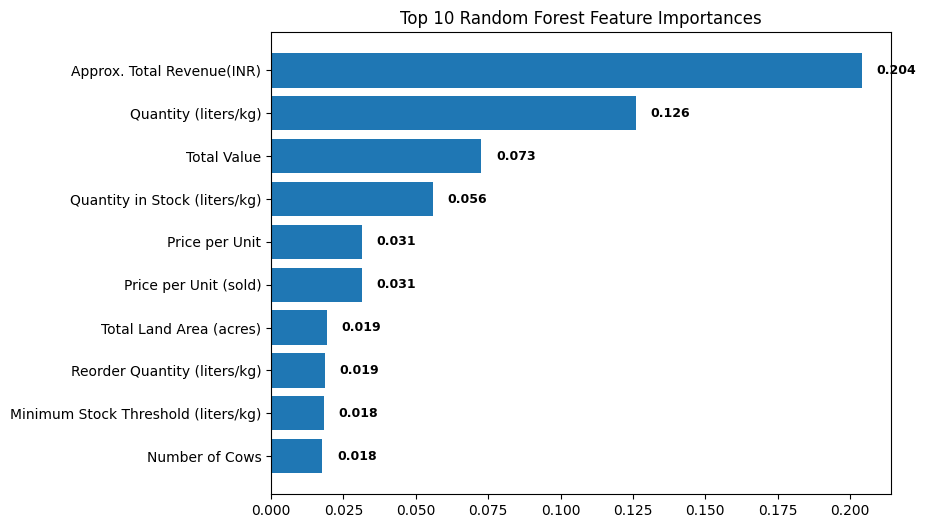

In [14]:
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Pick top 10 features
top_n = 10
top_indices = indices[:top_n]

plt.figure(figsize=(8,6))
bars = plt.barh(range(top_n), importances[top_indices], align="center")
plt.yticks(range(top_n), [X.columns[i] for i in top_indices])
plt.gca().invert_yaxis()
plt.title("Top 10 Random Forest Feature Importances")

# Add numbers at the end of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
             f"{importances[top_indices][i]:.3f}", va='center', fontsize=9, fontweight='bold')

plt.show()


In [15]:

joblib.dump(lr_model, "logistic_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("Models saved successfully!")


Models saved successfully!


Forecasting Metrics (Time-based Split):
MAE:  6.9359
MSE:  223.7063
RMSE: 14.9568
R2:   0.9950


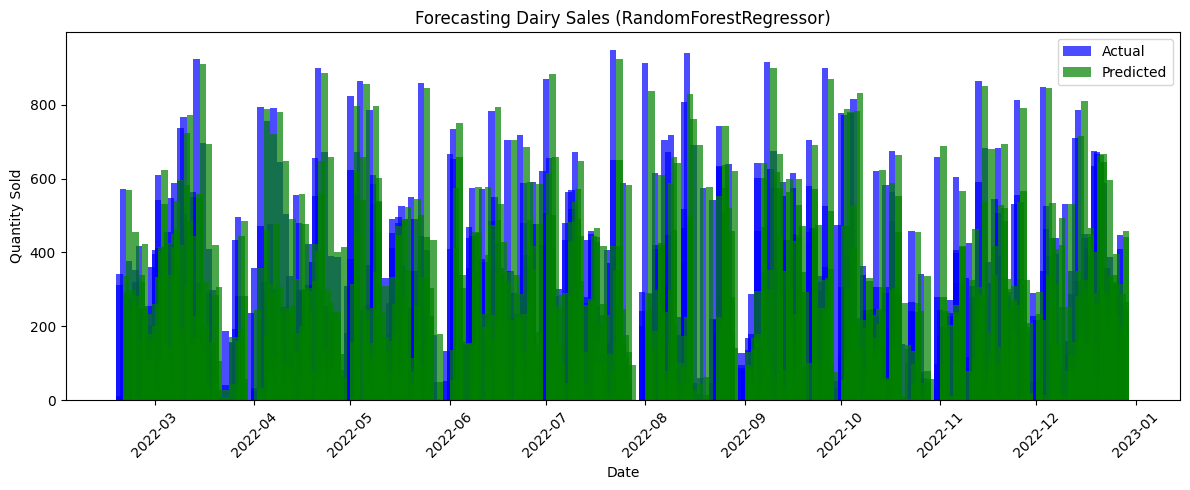

In [17]:
# === Simple Forecasting with RandomForestRegressor ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure Date is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Detect Quantity Sold column
qty_candidates = [c for c in df.columns if "Quantity" in c and "Sold" in c]
quantity_col = qty_candidates[0]

# Sort by date
df_sorted = df.sort_values("Date").reset_index(drop=True)

# Prepare features (drop target + Date)
X_forecast = df_sorted.drop(columns=[quantity_col, 'Date'])
y_forecast = df_sorted[quantity_col].astype(float)

# One-hot encode categoricals
X_forecast = pd.get_dummies(X_forecast, drop_first=True)

# Train-test split (80% train, 20% test by time)
split_idx = int(len(df_sorted) * 0.8)
X_train_f, X_test_f = X_forecast.iloc[:split_idx], X_forecast.iloc[split_idx:]
y_train_f, y_test_f = y_forecast.iloc[:split_idx], y_forecast.iloc[split_idx:]
dates_test = df_sorted['Date'].iloc[split_idx:]

# Train RandomForestRegressor
rf_forecast = RandomForestRegressor(n_estimators=200, random_state=42)
rf_forecast.fit(X_train_f, y_train_f)
y_pred_f = rf_forecast.predict(X_test_f)

# Metrics
mae_f = mean_absolute_error(y_test_f, y_pred_f)
mse_f = mean_squared_error(y_test_f, y_pred_f)
rmse_f = np.sqrt(mse_f)
r2_f = r2_score(y_test_f, y_pred_f)

print("Forecasting Metrics (Time-based Split):")
print(f"MAE:  {mae_f:.4f}")
print(f"MSE:  {mse_f:.4f}")
print(f"RMSE: {rmse_f:.4f}")
print(f"R2:   {r2_f:.4f}")

# === Clean Bar Chart for Actual vs Predicted ===
width = 3  # width of bars in days for clarity
plt.figure(figsize=(12,5))
plt.bar(dates_test - pd.Timedelta(days=1), y_test_f.values, 
        width=2, label="Actual", color="blue", alpha=0.7)
plt.bar(dates_test + pd.Timedelta(days=1), y_pred_f, 
        width=2, label="Predicted", color="green", alpha=0.7)

plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.title("Forecasting Dairy Sales (RandomForestRegressor)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
